# Opentender.eu datasets for Norway

## Load and transform dataset
Datasets downloaded in json format from https://opentender.eu/all/download for EU institutions. Extract and store the archives in `data_json_opentender/data-no-json`.

In [1]:
country_code = "no"

In [2]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        cpvs = element.get("cpvs", [])
        result_cpvs = []
        for cpv in cpvs:
            result = cpv.get("code", "na")
            if result and result != "na":
                result = result[:2]
                if result in all_divisions:
                    result_cpvs.append(result)
        title = element.get('title', '')
        if title:
            title = f'{title}. '
        description = element.get('description', '')

        title_description = f'{title}{description}'
        fastlid_output = fastlid(title_description)
        lang = fastlid_output[0]
        confidence = fastlid_output[1]
        #if lang == "en" and confidence > 0.4:
        if result_cpvs and title_description:
            lst = [title_description, result_cpvs]
            data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-no-json/data-no-2015.json', 'data_json_opentender/data-no-json/data-no-2012.json', 'data_json_opentender/data-no-json/data-no-year-unavailable.json', 'data_json_opentender/data-no-json/data-no-2014.json', 'data_json_opentender/data-no-json/data-no-2021.json', 'data_json_opentender/data-no-json/data-no-2020.json', 'data_json_opentender/data-no-json/data-no-2011.json', 'data_json_opentender/data-no-json/data-no-2009.json', 'data_json_opentender/data-no-json/data-no-2019.json', 'data_json_opentender/data-no-json/data-no-2010.json', 'data_json_opentender/data-no-json/data-no-2018.json', 'data_json_opentender/data-no-json/data-no-2016.json', 'data_json_opentender/data-no-json/data-no-2013.json', 'data_json_opentender/data-no-json/data-no-2017.json', 'data_json_opentender/data-no-json/data-no-2022.json']


title_description  \
235649  Anskaffelse av rehabiliteringsarbeider inngang...   
235650  Miljøsanering av bygning på festegrunn 84/1/32...   
235651  ERP-system. Oppdragsgiver skal anskaffe et ERP...   
235652  Skolemat i ungdomsskolen - Nes kommune. Anskaf...   
235653  MIDLERTIDIGE LOKALER KOMMUNEHUS OG SKOLE. Krød...   

                                        cpvs  
235649  [45, 45, 45, 45, 45, 45, 45, 45, 45]  
235650                              [45, 45]  
235651          [72, 48, 48, 48, 48, 72, 72]  
235652                      [15, 03, 15, 15]  
235653                  [45, 44, 45, 45, 45]

In [3]:
df.describe()

title_description    cpvs
count                                              235654  235654
unique                                             233036   17930
top     Dynamisk innkjøpsordning for delentrepriser. D...    [45]
freq                                                   17   49704

In [4]:
df.to_csv(f"data_json_opentender/notices_{country_code}_only_no_filters.csv")

In [5]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    token_list = text.split()
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    # finally, compute metrics
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [7]:
from ast import literal_eval
import glob
import json
import pandas as pd
from fastlid import fastlid


df = pd.read_csv(f'data_json_opentender/notices_{country_code}_only_no_filters.csv', converters={"cpvs": literal_eval}, index_col=0)

In [8]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description     71    44     50  \
0  Renovation of E18 (the European road 18) tunne...  False  True  False   

      80     73    45     85     79     90  ...     18     03     43     24  \
0  False  False  True  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  

[1 rows x 46 columns]

In [9]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                230625
unique                                               230625
top        renovation eNUMBER european road NUMBER tunne...
freq                                                      1
Name: title_description, dtype: object

In [10]:
df.to_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv")

In [7]:
import pandas as pd
df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv", index_col=0)
df.head()

title_description     71     44     50  \
0   renovation eNUMBER european road NUMBER tunne...  False   True  False   
1   ansk NUMBER network calculator NUMBER port ne...  False  False  False   
2   hire assistant manager strategy community pro...  False  False  False   
3   clean service asker church council tender con...  False  False  False   
4   float quay contracting authority enquiry conc...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False   True  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False   True  ...  False  False  False  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [8]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

Text(0.5, 0, 'CPV division')

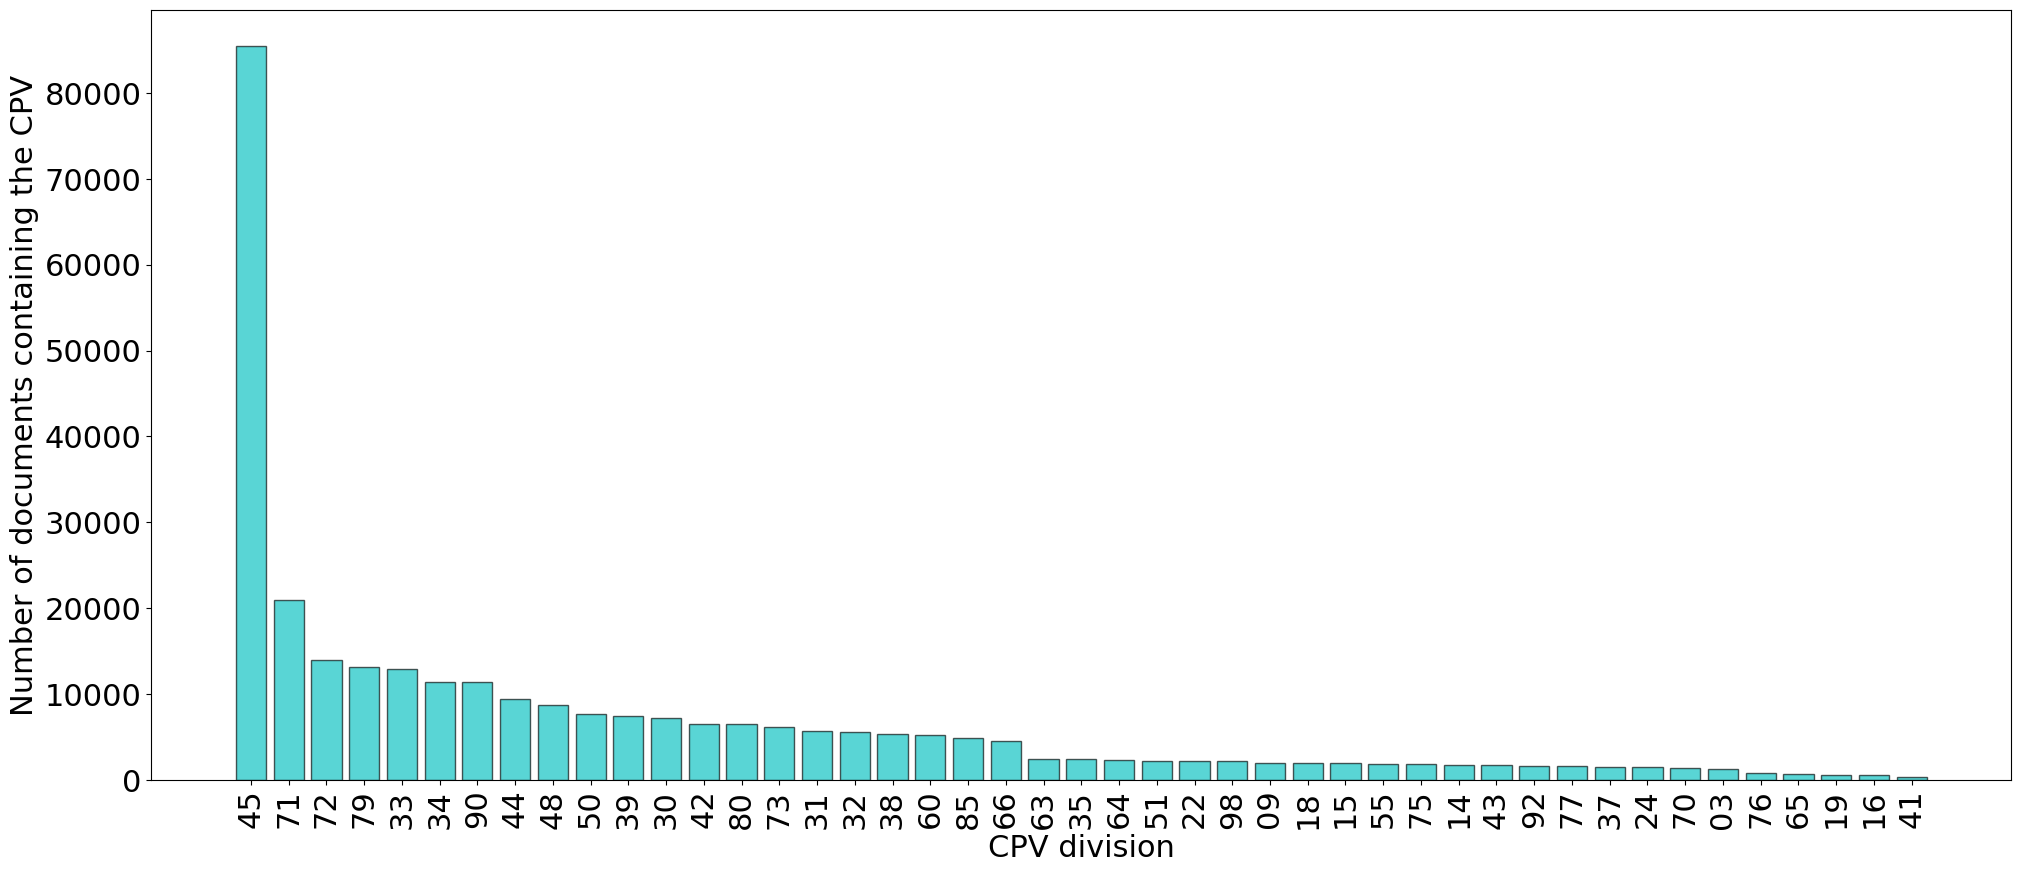

In [9]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


## Train model

In [10]:
from sklearn import metrics

X = df['title_description']
Y = df.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)


clf fit done


In [11]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.82      0.69      0.75      4166
          44       0.66      0.35      0.46      1933
          50       0.72      0.46      0.56      1474
          80       0.94      0.83      0.88      1289
          73       0.78      0.67      0.72      1267
          45       0.91      0.92      0.92     16859
          85       0.88      0.66      0.75       992
          79       0.78      0.64      0.70      2630
          90       0.88      0.75      0.81      2282
          30       0.85      0.64      0.73      1456
          35       0.71      0.32      0.44       432
          33       0.86      0.81      0.83      2543
          55       0.93      0.76      0.84       401
          72       0.72      0.66      0.69      2754
          48       0.69      0.60      0.64      1743
          38       0.78      0.63      0.70      1089
          09       0.89      0.68      0.77       392
          75       0.64    

## Predictions on data from other countries

In [12]:
list_of_countries = ["ie", "no", "uk", "eu"]
list_of_countries.remove(country_code)

for country in list_of_countries:
    df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country}_only_no_filters.csv", index_col=0)
    print("====================================================\n")
    print(f"Country: {country}")
    X = df['title_description']
    Y = df.drop(['title_description'], axis=1)
    y_pred = SVC_pipeline.predict(X)
    print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
    print(multi_label_metrics(Y, y_pred))
    print("====================================================\n")



Country: ie


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.83      0.38      0.52     14326
          44       0.39      0.05      0.08      5163
          50       0.51      0.29      0.37      5009
          80       0.81      0.30      0.43      4701
          73       0.47      0.22      0.30      3487
          45       0.85      0.63      0.72     23424
          85       0.67      0.12      0.20      2068
          79       0.75      0.36      0.49     13945
          90       0.83      0.38      0.52      4534
          30       0.65      0.33      0.43      3096
          35       0.54      0.07      0.13      1804
          33       0.64      0.47      0.54      3953
          55       0.88      0.43      0.57      1419
          72       0.69      0.46      0.55     10273
          48       0.54      0.35      0.43      4918
          38       0.76      0.32      0.45      3699
          09       0.57      0.39      0.46       957
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.60      0.24      0.34     32218
          44       0.46      0.08      0.13     14264
          50       0.50      0.38      0.43     20363
          80       0.81      0.24      0.37     18155
          73       0.47      0.25      0.33     19875
          45       0.75      0.48      0.59     63683
          85       0.85      0.13      0.22     33984
          79       0.63      0.36      0.46     48598
          90       0.78      0.51      0.61     17154
          30       0.48      0.32      0.38      7103
          35       0.42      0.08      0.13      5395
          33       0.52      0.44      0.48     14999
          55       0.85      0.46      0.59      5015
          72       0.42      0.46      0.44     28095
          48       0.55      0.41      0.47     20149
          38       0.66      0.31      0.42     11902
          09       0.63      0.38      0.48      4144
          75       0.01    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          71       0.22      0.07      0.10       465
          44       0.11      0.01      0.01      1604
          50       0.42      0.03      0.05       848
          80       0.68      0.32      0.43       230
          73       0.38      0.33      0.36       428
          45       0.03      0.21      0.05       436
          85       0.45      0.02      0.04       249
          79       0.66      0.23      0.35      1352
          90       0.43      0.16      0.24       331
          30       0.83      0.21      0.34      2189
          35       0.08      0.01      0.02       236
          33       0.53      0.17      0.26      7918
          55       0.76      0.31      0.44        95
          72       0.45      0.40      0.43       493
          48       0.19      0.16      0.17       171
          38       0.30      0.14      0.19       279
          09       0.38      0.08      0.14       168
          75       0.00    

## Predictions on dataset since january 2023
Dataset available on S3: s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20220221-dataset_since_january_2023.csv ; 

In [16]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [17]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline.predict(X)
print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

              precision    recall  f1-score   support

          71       0.29      0.22      0.25         9
          44       0.00      0.00      0.00         1
          50       1.00      0.33      0.50         3
          80       1.00      0.67      0.80         6
          73       0.00      0.00      0.00         7
          45       0.87      0.93      0.90        14
          85       1.00      0.33      0.50         3
          79       0.78      0.69      0.73        26
          90       0.80      0.57      0.67         7
          30       0.67      1.00      0.80         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.60      0.86      0.71         7
          48       0.50      1.00      0.67         2
          38       0.50      1.00      0.67         1
          09       0.00      0.00      0.00         0
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

# With Filters above/below thresholds

In [18]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs', 'size']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        size = element.get("size", None)
        if size:
            cpvs = element.get("cpvs", [])
            result_cpvs = []
            for cpv in cpvs:
                result = cpv.get("code", "na")
                if result and result != "na":
                    result = result[:2]
                    if result in all_divisions:
                        result_cpvs.append(result)
            title = element.get('title', '')
            if title:
                title = f'{title}. '
            description = element.get('description', '')

            title_description = f'{title}{description}'
            if result_cpvs and title_description:
                lst = [title_description, result_cpvs, size]
                data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-no-json/data-no-2015.json', 'data_json_opentender/data-no-json/data-no-2012.json', 'data_json_opentender/data-no-json/data-no-year-unavailable.json', 'data_json_opentender/data-no-json/data-no-2014.json', 'data_json_opentender/data-no-json/data-no-2021.json', 'data_json_opentender/data-no-json/data-no-2020.json', 'data_json_opentender/data-no-json/data-no-2011.json', 'data_json_opentender/data-no-json/data-no-2009.json', 'data_json_opentender/data-no-json/data-no-2019.json', 'data_json_opentender/data-no-json/data-no-2010.json', 'data_json_opentender/data-no-json/data-no-2018.json', 'data_json_opentender/data-no-json/data-no-2016.json', 'data_json_opentender/data-no-json/data-no-2013.json', 'data_json_opentender/data-no-json/data-no-2017.json', 'data_json_opentender/data-no-json/data-no-2022.json']


title_description  \
43939  Prosjektering og bygging av leilighetsbygg på ...   
43940  KK - Rammeavtale - Elektrikertjenester og serv...   
43941  Tilbygg Belehalli. Sogndal Kommune ønskjer å f...   
43942  Valestrand busslomme og parkering - Ny utlysin...   
43943  Anskaffelse av rehabiliteringsarbeider inngang...   

                                       cpvs                 size  
43939                  [45, 39, 45, 45, 71]  BELOW_THE_THRESHOLD  
43940                          [45, 45, 45]  BELOW_THE_THRESHOLD  
43941              [45, 45, 45, 45, 45, 45]  BELOW_THE_THRESHOLD  
43942                                  [45]  BELOW_THE_THRESHOLD  
43943  [45, 45, 45, 45, 45, 45, 45, 45, 45]  BELOW_THE_THRESHOLD

In [19]:
df = df.drop_duplicates(subset=['title_description'], keep='last')

In [20]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description                 size  \
0  Renovation of E18 (the European road 18) tunne...  ABOVE_THE_THRESHOLD   

      71    44     50     80     73    45     85     79  ...     18     03  \
0  False  True  False  False  False  True  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  

[1 rows x 47 columns]

In [21]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                 43361
unique                                                43361
top        renovation eNUMBER european road NUMBER tunne...
freq                                                      1
Name: title_description, dtype: object

In [22]:
df.to_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv")

In [23]:
df = pd.read_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv", index_col=0)

In [24]:
df["size"].describe()

count                   43361
unique                      2
top       BELOW_THE_THRESHOLD
freq                    22511
Name: size, dtype: object

In [25]:
df["size"].unique()

array(['ABOVE_THE_THRESHOLD', 'BELOW_THE_THRESHOLD'], dtype=object)

In [26]:
df_below_threshold = df[df["size"] == "BELOW_THE_THRESHOLD"]
df_above_threshold = df[df["size"] == "ABOVE_THE_THRESHOLD"]
df_below_threshold.head()

title_description                 size  \
2    clean service asker church council tender con...  BELOW_THE_THRESHOLD   
8    purchase wheel loader purchase wheeled loader...  BELOW_THE_THRESHOLD   
9    NUMBER firefighting vehicle oslo airport plan...  BELOW_THE_THRESHOLD   
14   NUMBERd laparoscopy rack NUMBERd laparoscopy ...  BELOW_THE_THRESHOLD   
25   leasing pc teacher ovre eiker municipality re...  BELOW_THE_THRESHOLD   

       71     44     50     80     73     45     85     79  ...     18     03  \
2   False  False  False  False  False  False  False  False  ...  False  False   
8   False  False  False  False  False  False  False  False  ...  False  False   
9   False  False  False  False  False  False  False  False  ...  False  False   
14  False  False  False  False  False  False  False  False  ...  False  False   
25  False  False  False  False  False  False  False  False  ...  False  False   

       43     24     19     41     37     14     16     76  
2   False  False  False  False  False  False  False  False  
8   False  False  False  False  False  False  False  False  
9   False  False  False  False  False  False  False  False  
14  False  False  False  False  False  False  False  False  
25  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

Text(0.5, 0, 'CPV division')

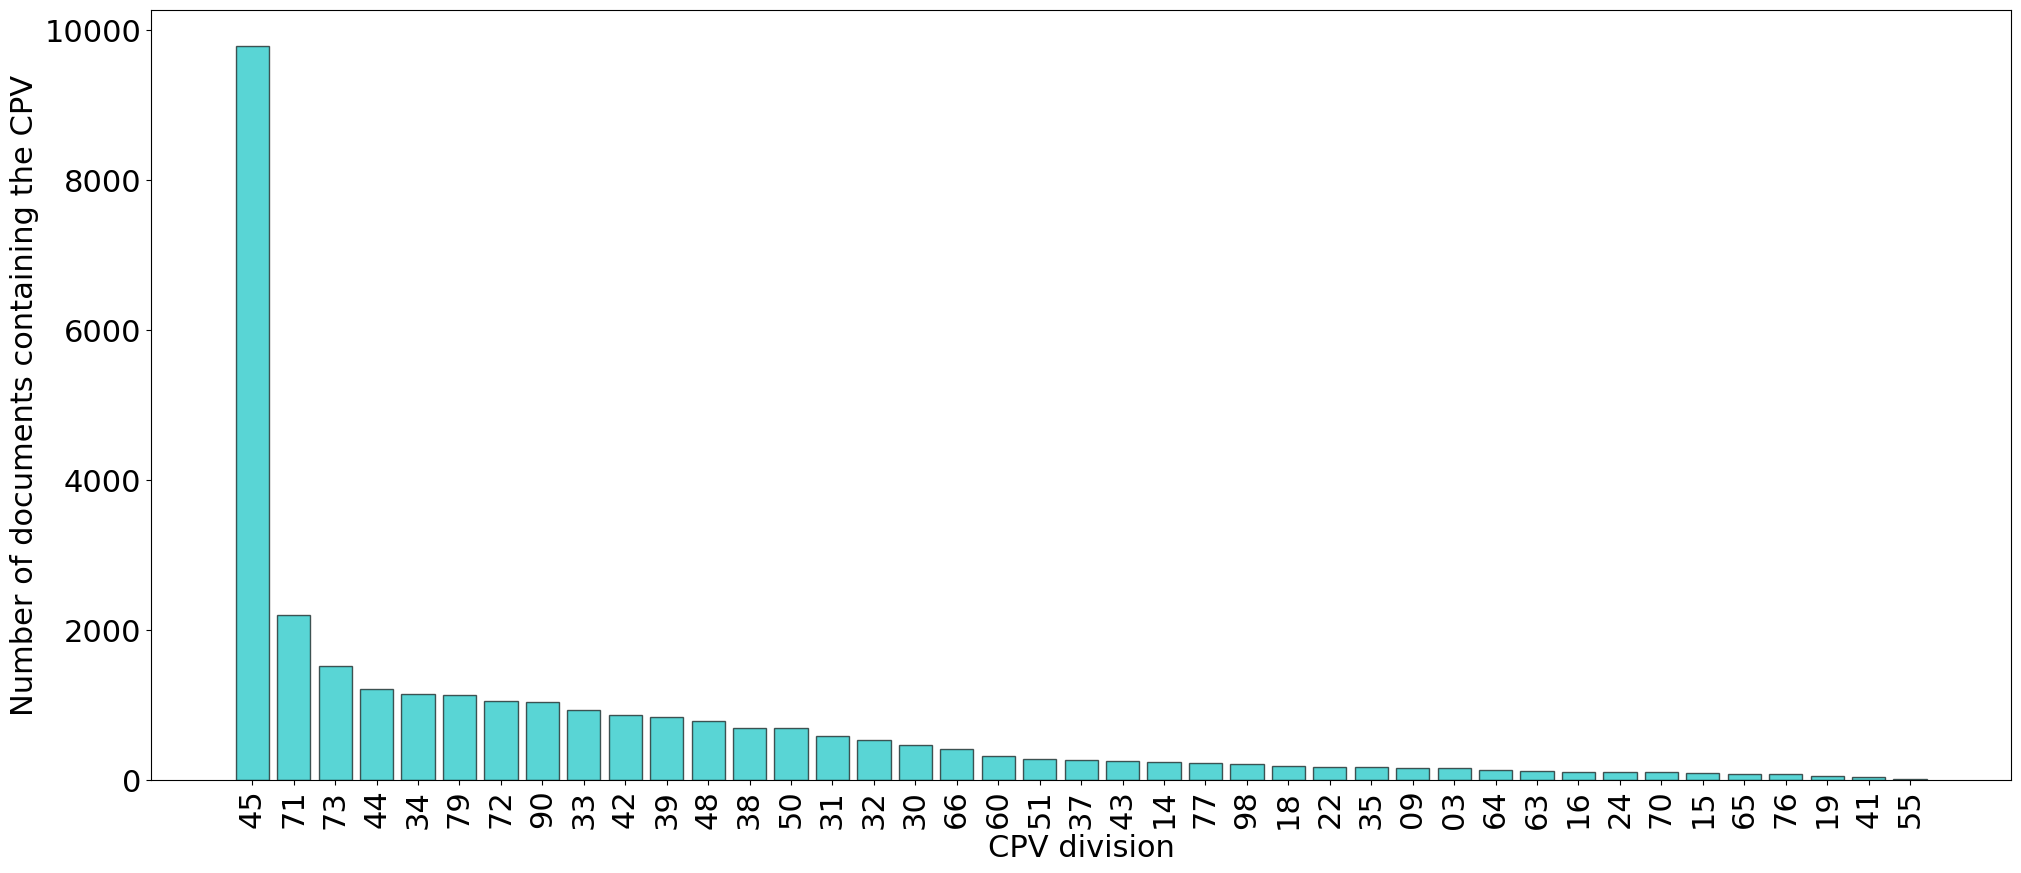

In [27]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_below_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


Text(0.5, 0, 'CPV division')

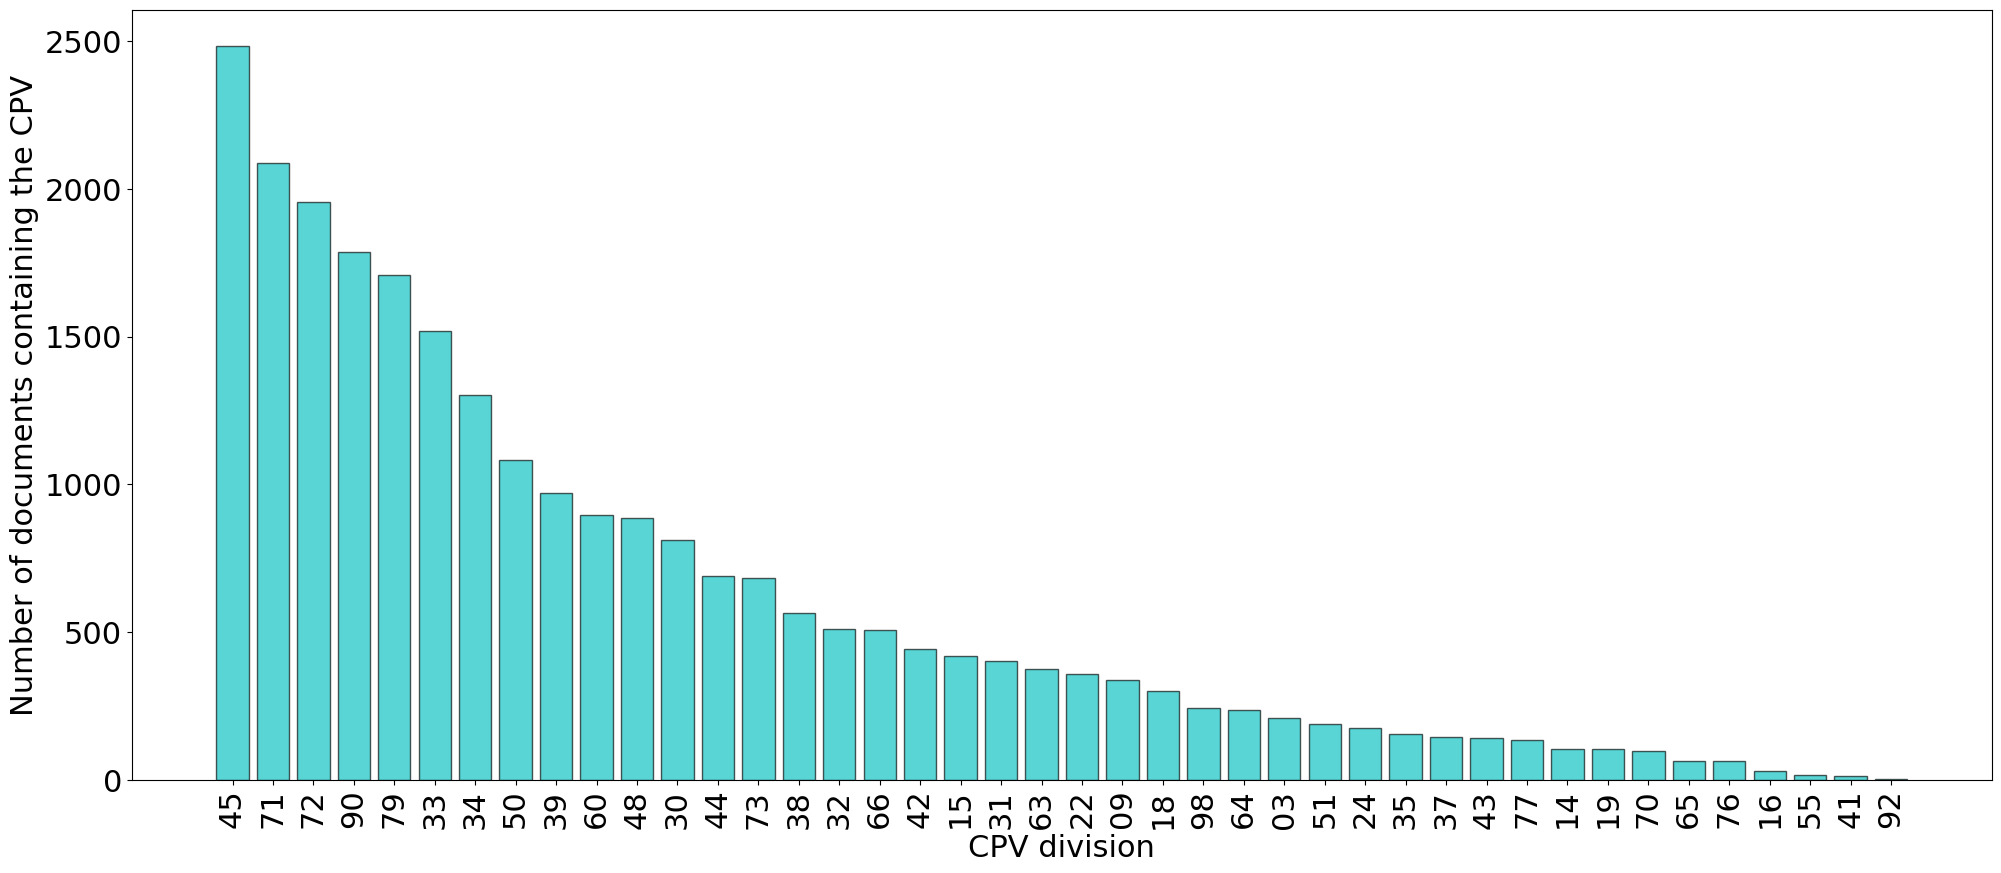

In [28]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_above_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


In [29]:
df_below_threshold.describe()

title_description  \
count                                               22511   
unique                                              22511   
top      clean service asker church council tender con...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                 22511  22511  22511  22511  22511  22511  22511  22511   
unique                    1      2      2      2      1      2      2      1   
top     BELOW_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                  22511  20316  21297  21823  22511  20998  12724  22511   

           79  ...     18     03     43     24     19     41     37     14  \
count   22511  ...  22511  22511  22511  22511  22511  22511  22511  22511   
unique      2  ...      2      2      2      2      2      2      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq    21384  ...  22323  22355  22264  22409  22464  22480  22251  22277   

           16     76  
count   22511  22511  
unique      2      2  
top     False  False  
freq    22403  22439  

[4 rows x 47 columns]

In [30]:
df_above_threshold.describe()

title_description  \
count                                               20850   
unique                                              20850   
top      renovation eNUMBER european road NUMBER tunne...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                 20850  20850  20850  20850  20850  20850  20850  20850   
unique                    1      2      2      2      1      2      2      1   
top     ABOVE_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                  20850  18764  20161  19769  20850  20167  18368  20850   

           79  ...     18     03     43     24     19     41     37     14  \
count   20850  ...  20850  20850  20850  20850  20850  20850  20850  20850   
unique      2  ...      2      2      2      2      2      2      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq    19142  ...  20551  20641  20709  20675  20747  20836  20705  20745   

           16     76  
count   20850  20850  
unique      2      2  
top     False  False  
freq    20821  20788  

[4 rows x 47 columns]

In [31]:
df_above_threshold.head()

title_description                 size  \
0   renovation eNUMBER european road NUMBER tunne...  ABOVE_THE_THRESHOLD   
1   hire assistant manager strategy community pro...  ABOVE_THE_THRESHOLD   
3   float quay contracting authority enquiry conc...  ABOVE_THE_THRESHOLD   
4   printing distribution helse vest helse vest r...  ABOVE_THE_THRESHOLD   
5   procurement ict licence accompany consultancy...  ABOVE_THE_THRESHOLD   

      71     44     50     80     73     45     85     79  ...     18     03  \
0  False   True  False  False  False   True  False  False  ...  False  False   
1  False  False  False  False  False  False  False   True  ...  False  False   
3  False  False  False  False  False  False  False  False  ...  False  False   
4  False  False  False  False  False  False  False  False  ...  False  False   
5  False  False  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  
5  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

In [32]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
df_above_threshold = df_above_threshold.drop(["size"], axis = 1)
df_below_threshold = df_below_threshold.drop(["size"], axis = 1)

In [33]:
from sklearn import metrics

X = df_above_threshold['title_description']
Y = df_above_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_above = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_above.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_above.predict(X_test)
print("Above threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(


clf fit done
Above threshold: 

              precision    recall  f1-score   support

          71       0.82      0.68      0.74       419
          44       0.77      0.48      0.59       124
          50       0.69      0.50      0.58       226
          80       0.00      0.00      0.00         0
          73       0.74      0.67      0.70       122
          45       0.86      0.75      0.80       510
          85       0.00      0.00      0.00         0
          79       0.82      0.64      0.72       369
          90       0.89      0.83      0.86       361
          30       0.87      0.61      0.72       170
          35       0.50      0.06      0.10        36
          33       0.88      0.79      0.83       307
          55       0.00      0.00      0.00         7
          72       0.72      0.67      0.69       413
          48       0.68      0.39      0.50       191
          38       0.64      0.50      0.56       105
          09       0.89      0.82      0.86      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

{'f1': 0.7066001109262341, 'roc_auc': 0.8104896359433373, 'accuracy': 0.5829736211031175, 'coverage_error': 16.526378896882495, 'label_ranking_average_precision_score': 0.6591640497126099}
None


In [34]:
from sklearn import metrics

X = df_below_threshold['title_description']
Y = df_below_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_below = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_below.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_below.predict(X_test)
print("Below threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


clf fit done
Below threshold: 

              precision    recall  f1-score   support

          71       0.74      0.44      0.56       458
          44       0.70      0.21      0.33       230
          50       0.56      0.21      0.30       150
          80       0.00      0.00      0.00         0
          73       0.82      0.82      0.82       310
          45       0.89      0.92      0.90      1931
          85       0.00      0.00      0.00         0
          79       0.70      0.34      0.46       225
          90       0.89      0.60      0.71       191
          30       0.76      0.32      0.45        91
          35       0.40      0.07      0.12        28
          33       0.73      0.60      0.66       187
          55       0.00      0.00      0.00         2
          72       0.71      0.36      0.47       225
          48       0.60      0.35      0.45       155
          38       0.79      0.31      0.45       157
          09       0.82      0.44      0.57      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

{'f1': 0.6764585883312932, 'roc_auc': 0.7858086995189637, 'accuracy': 0.5265378636464579, 'coverage_error': 19.691538974017323, 'label_ranking_average_precision_score': 0.6160013253950628}
None


## Against eu institution notices from january 2023

In [35]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [36]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_above.predict(X)
print("Above threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Above threshold: 

              precision    recall  f1-score   support

          71       0.50      0.56      0.53         9
          44       0.00      0.00      0.00         1
          50       0.50      0.33      0.40         3
          80       0.00      0.00      0.00         6
          73       0.00      0.00      0.00         7
          45       0.82      0.64      0.72        14
          85       0.00      0.00      0.00         3
          79       0.87      0.50      0.63        26
          90       0.80      0.57      0.67         7
          30       0.50      0.50      0.50         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         2
          72       0.45      0.71      0.56         7
          48       0.50      1.00      0.67         2
          38       0.33      1.00      0.50         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [37]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_below.predict(X)
print("Below threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Below threshold: 

              precision    recall  f1-score   support

          71       0.50      0.56      0.53         9
          44       0.00      0.00      0.00         1
          50       0.00      0.00      0.00         3
          80       0.00      0.00      0.00         6
          73       0.00      0.00      0.00         7
          45       0.90      0.64      0.75        14
          85       0.00      0.00      0.00         3
          79       0.90      0.35      0.50        26
          90       1.00      0.43      0.60         7
          30       0.00      0.00      0.00         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         2
          72       0.50      0.71      0.59         7
          48       0.00      0.00      0.00         2
          38       0.00      0.00      0.00         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a